In [1]:
import pandas as pd

** Importing data **

In [2]:
df = pd.read_csv('./creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There are no null values

In [6]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
df['Class'].value_counts()[1] / df['Class'].value_counts()[0]

0.0017304750013189597

We have about 0.17% fraud cases. Let's separate the fraud and valid transactions

In [29]:
fraud = df[df['Class'] == 1]
valid = df[df['Class'] == 0]

In [30]:
fraud.shape

(492, 31)

In [31]:
valid.shape

(284315, 31)

Let's look at the distribution of the amount in fraud vs. valid case

In [32]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [33]:
valid.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Let's have a more graphical representation for the distribution of the amount

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

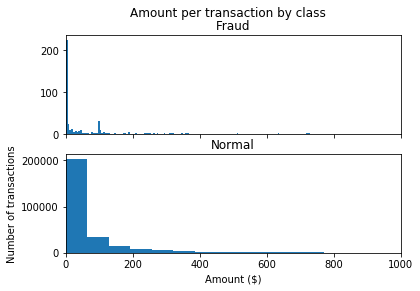

In [71]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
#sharex=True allows both the subplots to share the same X axis. 
f.suptitle('Amount per transaction by class')

numberBins = 400

ax1.hist(fraud.Amount, bins=numberBins);
ax1.set_title('Fraud')

ax2.hist(valid.Amount, bins=numberBins);
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of transactions')
plt.xlim((0, 1000));
#plt.yscale('log')